# My Q-Learning Agent:

In [19]:
import pandas as pd

data = pd.read_csv('data_sample_one_year.csv')

data = data.iloc[:, [0,3]]
data.rename(columns={'high':'close'}, inplace=True)

from talib import RSI
data['rsi'] = RSI(data['close'])

data.dropna(axis=0)

,timestamp,close,rsi
14,1675864800,1661.40,43.483899
15,1675868400,1651.57,35.387550
16,1675879200,1641.08,29.150096
17,1675882800,1642.42,30.827374
18,1675886400,1636.22,27.574649
...,...,...,...
8092,1707336000,2418.66,79.801442
8093,1707339600,2424.86,81.156058
8094,1707343200,2421.03,77.689871
8095,1707346800,2421.81,77.896916


<Axes: >

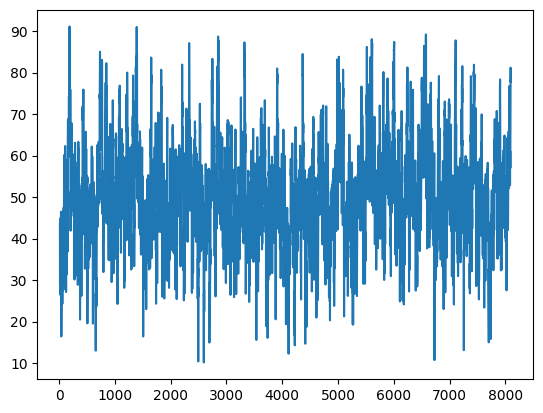

In [2]:
data['rsi'].plot()

In [3]:
states = ['long+', 'long-', 'short+', 'short-', 'offtrade']
actions = ['buy', 'sell', 'hold']

# My First Trial

In [10]:
import numpy as np

class MyQLearningAgent:
    def __init__(self, data, states, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.data = data
        
        self.states = states
        self.actions = actions
        self.pseudo_actions = []
        
        self.num_states = len(states)
        self.num_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((self.num_states, self.num_actions))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.Q[self.states.index(state)])]

    def update_q_table(self, state, action, reward, next_state):
        self.Q[self.states.index(state), self.actions.index(action)] += self.alpha * (
                reward + self.gamma * np.max(self.Q[self.states.index(next_state)]) -
                self.Q[self.states.index(state), self.actions.index(action)])

    def train(self, num_episodes):
        for episode in range(num_episodes):
            
            i = 0
            total_reward = 0

            price_open = self.data['close'].iloc[i] # position open price
            delta_price = self.data['close'].iloc[i+1] - price_open

            if delta_price > 0:
                state = np.random.choice(['long+', 'short-'])
            elif delta_price < 0:
                state = np.random.choice(['long-', 'short+'])
            else:
                state = 'offtrade'

            for j in range(i+2, len(self.data['close'])):
                if state == 'long+' or state == 'long-':
                    self.pseudo_actions = ['sell', 'hold']
                elif state == 'short+' or state == 'short-':
                    self.pseudo_actions = ['buy', 'hold']
                elif state == 'offtrade':
                    self.pseudo_actions = ['buy', 'sell']

                while True:
                    action = None
                    while not action in self.pseudo_actions:
                        action = self.choose_action(state)
                    
                    if action == 'hold':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)
                        next_state = state
                        self.update_q_table(state, action, reward, next_state)
                        
                    elif action == 'buy':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)

                        if reward > 0:
                            next_state = 'offtrade'
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state
                        else:
                            #next_state = np.random.choice(['long+', 'long-'])
                            next_state = state
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state

                    elif action == 'sell':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)

                        if reward > 0:
                            next_state = 'offtrade'
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state
                        else:
                            #next_state = np.random.choice(['short+', 'short-'])
                            next_state = state
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state
                    
                    # Check for terminal state
                    if state == 'offtrade':
                        break

                i += 1
                total_reward += reward

            print("Episode {}: Total Reward = {}".format(episode + 1, total_reward))
            
    def get_reward(self, state, action, delta_price=0):

        if state == 'long+' and action == 'sell':
            #return delta_price if delta_price > 0 else -5
            return 15 if delta_price > 0 else -5
        elif state == 'long+' and action == 'hold':
            return 2 if delta_price > 0 else -2
        elif state == 'short+' and action == 'buy':
            #return delta_price if delta_price > 0 else -5
            return 15 if delta_price < 0 else -5
        elif state == 'short-' and action == 'hold':
            return 2 if delta_price < 0 else -2
        elif state == 'offtrade' and action == 'buy':
            return 5 if delta_price > 0 else -5
        elif state == 'offtrade' and action == 'sell':
            return 5 if delta_price < 0 else -5
        else:
            return 0

In [4]:
data = data.iloc[:500]

In [32]:
agent = MyQLearningAgent(data, states, actions)
agent.train(num_episodes=13)

KeyboardInterrupt: 

In [18]:
agent.Q

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -2.],
       [ 0.,  0.,  0.]])

- parameter: coeff & (j-i) * delta_price to maximize

- return rewards with normalized delta values

# My second trial:

In [5]:
import numpy as np

class MyQLearningAgent2:
    def __init__(self, data, states, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.data = data
        
        self.states = states
        self.actions = actions
        self.pseudo_actions = []
        
        self.num_states = len(states)
        self.num_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((self.num_states, self.num_actions))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.Q[self.states.index(state)])]

    def update_q_table(self, state, action, reward, next_state):
        self.Q[self.states.index(state), self.actions.index(action)] += self.alpha * (
                reward + self.gamma * np.max(self.Q[self.states.index(next_state)]) -
                self.Q[self.states.index(state), self.actions.index(action)])

    def train(self, num_episodes):
        for episode in range(num_episodes):
            
            i = 0
            total_reward = 0

            price_open = self.data['close'].iloc[i] # position open price
            delta_price = self.data['close'].iloc[i+1] - price_open

            if delta_price > 0:
                state = np.random.choice(['long+', 'short-'])
            elif delta_price < 0:
                state = np.random.choice(['long-', 'short+'])
            else:
                state = 'offtrade'

            for j in range(i+2, len(self.data['close'])):
                if state == 'long+' or state == 'long-':
                    self.pseudo_actions = ['sell', 'hold']
                elif state == 'short+' or state == 'short-':
                    self.pseudo_actions = ['buy', 'hold']
                elif state == 'offtrade':
                    self.pseudo_actions = ['buy', 'sell']

                while True:
                    action = None
                    while not action in self.pseudo_actions:
                        action = self.choose_action(state)
                    
                    if action == 'hold':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)
                        next_state = state
                        self.update_q_table(state, action, reward, next_state)
                        
                    elif action == 'buy':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)

                        if state.startswith('short'):
                            next_state = 'offtrade'
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state
                        else:
                            if delta_price > 0:
                                next_state = 'short-'
                            else:
                                next_state = 'short+'
                            
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state

                    elif action == 'sell':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)

                        if state.startswith('long'):
                            next_state = 'offtrade'
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state
                        else:
                            if delta_price > 0:
                                next_state = 'long+'
                            else:
                                next_state = 'long-'
                            
                            self.update_q_table(state, action, reward, next_state)
                            state = next_state
                    
                    # Check for terminal state
                    if state == 'offtrade':
                        break

                i += 1
                total_reward += reward

            print("Episode {}: Total Reward = {}".format(episode + 1, total_reward))
            
    def get_reward(self, state, action, delta_price=0):

        if state.startswith('long') and action == 'sell':
            #return delta_price if delta_price > 0 else -5
            return 15 if delta_price > 0 else -5
        elif state.startswith('long') and action == 'hold':
            return 2 if delta_price > 0 else -2
        elif state.startswith('short') and action == 'buy':
            #return delta_price if delta_price > 0 else -5
            return 15 if delta_price < 0 else -5
        elif state.startswith('short') and action == 'hold':
            return 2 if delta_price < 0 else -2
        elif state == 'offtrade' and action == 'buy':
            return 5 if delta_price > 0 else -5
        elif state == 'offtrade' and action == 'sell':
            return 5 if delta_price < 0 else -5
        else:
            return 0

In [6]:
agent2 = MyQLearningAgent2(data, states, actions)
agent2.train(num_episodes=50)

Episode 1: Total Reward = 7370
Episode 2: Total Reward = 7290
Episode 3: Total Reward = 7230
Episode 4: Total Reward = 7350
Episode 5: Total Reward = 7230
Episode 6: Total Reward = 7210
Episode 7: Total Reward = 7110
Episode 8: Total Reward = 7170
Episode 9: Total Reward = 7230
Episode 10: Total Reward = 7270
Episode 11: Total Reward = 7150
Episode 12: Total Reward = 7190
Episode 13: Total Reward = 7290
Episode 14: Total Reward = 7070
Episode 15: Total Reward = 7150
Episode 16: Total Reward = 7210
Episode 17: Total Reward = 7130
Episode 18: Total Reward = 7090
Episode 19: Total Reward = 7110
Episode 20: Total Reward = 7110
Episode 21: Total Reward = 7230
Episode 22: Total Reward = 7070
Episode 23: Total Reward = 7210
Episode 24: Total Reward = 7230
Episode 25: Total Reward = 7170
Episode 26: Total Reward = 7190
Episode 27: Total Reward = 7230
Episode 28: Total Reward = 7130
Episode 29: Total Reward = 7110
Episode 30: Total Reward = 7210
Episode 31: Total Reward = 7290
Episode 32: Total

In [7]:
agent2.Q

array([[56.46693178, 70.12450625,  0.        ],
       [64.26436126, 50.8528559 ,  0.        ],
       [71.4559264 , 57.48653161,  0.        ],
       [50.09692381, 63.13626598, 47.77447413],
       [58.57049321, 62.78156933,  0.        ]])

# My 3rd Trial

In [9]:
import numpy as np

class MyQLearningAgent3:
    def __init__(self, data, states, actions, alpha=0.3, gamma=0.7, epsilon=0.3):
        self.data = data
        
        self.states = states
        self.actions = actions
        self.pseudo_actions = []
        
        self.num_states = len(states)
        self.num_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((self.num_states, self.num_actions))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.Q[self.states.index(state)])]

    def update_q_table(self, state, action, reward, next_state):
        self.Q[self.states.index(state), self.actions.index(action)] += self.alpha * (
                reward + self.gamma * np.max(self.Q[self.states.index(next_state)]) -
                self.Q[self.states.index(state), self.actions.index(action)])

    def train(self, num_episodes):
        for episode in range(num_episodes):
            total_reward = 0
            state = 'offtrade'

            for i in range(1, len(self.data)):
                price_open = self.data['close'].iloc[i] # position open price
                delta_price = self.data['close'].iloc[i-1] - price_open

                if delta_price >= 0:
                    state = np.random.choice(['long+', 'short-'])
                elif delta_price < 0:
                    state = np.random.choice(['long-', 'short+'])

                if state == 'long+' or state == 'long-':
                    self.pseudo_actions = ['sell', 'hold']
                elif state == 'short+' or state == 'short-':
                    self.pseudo_actions = ['buy', 'hold']

                j = i+1
                while j < len(self.data):
                    action = None
                    while not action in self.pseudo_actions:
                        action = self.choose_action(state)

                    if action == 'hold':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)
                        next_state = state
                        self.update_q_table(state, action, reward, next_state)

                    elif action == 'buy':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)

                        assert state.startswith('short')

                        next_state = 'offtrade'
                        self.update_q_table(state, action, reward, next_state)
                        stat = next_state

                    elif action == 'sell':
                        delta_price = self.data['close'].iloc[j] - price_open
                        reward = self.get_reward(state, action, delta_price)

                        assert state.startswith('long')

                        next_state = 'offtrade'
                        self.update_q_table(state, action, reward, next_state)
                        state = next_state

                    j += 1

                    # Check for terminal state
                    if state == 'offtrade':
                        break

                total_reward += reward

            print("Episode {}: Total Reward = {}".format(episode + 1, total_reward))
            # ---------------------------------------------------
    
    def get_reward(self, state, action, delta_price=0):

        if state.startswith('long') and action == 'sell':
            #return delta_price if delta_price > 0 else -5
            return 15 if delta_price > 0 else -5
        elif state.startswith('long') and action == 'hold':
            return 2 if delta_price > 0 else -2
        elif state.startswith('short') and action == 'buy':
            #return delta_price if delta_price > 0 else -5
            return 15 if delta_price < 0 else -5
        elif state.startswith('short') and action == 'hold':
            return 2 if delta_price < 0 else -2
        elif state == 'offtrade' and action == 'buy':
            return 5 if delta_price > 0 else -5
        elif state == 'offtrade' and action == 'sell':
            return 5 if delta_price < 0 else -5
        else:
            return 0

In [11]:
agent3 = MyQLearningAgent3(data, states, actions)
agent3.train(num_episodes=5)

KeyboardInterrupt: 

In [12]:
agent3.Q

array([[ 0.        ,  2.93877873,  0.0531734 ],
       [ 0.        ,  5.88360883,  1.8520081 ],
       [-5.        ,  0.        , -2.        ],
       [-5.        ,  0.        , -2.        ],
       [ 0.        ,  0.        ,  0.        ]])

- at each step, relative state is + or -

- define normalized rewards

- states should be vectorized

# states:
- offtrade 0, long 1, short 2

- '.' 0, '+' 1, '-' 2: relative position

- neutral 0, profit 1, loss 2

#### example:
nb of states: 3 * 3 * 3 = 27

state(noX) = [1, 1, 1] which means long with profit whose price is up

# actions:

- hold 0, buy 1, sell 2

note: reward befor/after the next_state?

In [2]:
states_trade = {'offtrade': 0, 'long': 1, 'short': 2}
states_relative = {'neutral': 0, 'positive': 1, 'negative': 2}
states_global = {'neutral': 0, 'profit': 1, 'loss': 2}

In [3]:
import itertools

state_space = []
for combo in itertools.product(states_trade.values(), states_relative.values(), states_global.values()):
    state_space.append(combo)

In [4]:
actions = {'hold': 0, 'buy': 1, 'sell': 2}
action_space = [i for i in actions.values()]

In [13]:
import numpy as np

class MyQLearningAgent4:
    def __init__(self, data, states, actions, alpha=0.3, gamma=0.7, epsilon=0.3):
        self.data = data
        
        self.states = states
        self.actions = actions
        self.pseudo_actions = []
        
        self.num_states = len(states)
        self.num_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((self.num_states, self.num_actions))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.Q[self.states.index(state)])]

    def update_q_table(self, state, action, reward, next_state):
        self.Q[self.states.index(state), self.actions.index(action)] += self.alpha * (
                reward + self.gamma * np.max(self.Q[self.states.index(next_state)]) -
                self.Q[self.states.index(state), self.actions.index(action)])

    def train(self, num_episodes):
        for episode in range(num_episodes):
            total_reward = 0
            state = [0, 0, 0]

            for i in range(1, len(self.data)):
                price_open = self.data['close'].iloc[i] # position open price
                price_recent = self.data['close'].iloc[i-1] - price_open

                if price_recent > 0:
                    state[1] = 1
                elif price_recent < 0:
                    state[1] = 2
                else:
                    state[1] = 0

                if state[0] == 0:
                    self.pseudo_actions = [1, 2]
                elif state[0] == 1:
                    self.pseudo_actions = [0, 2]
                elif state[0] == 2:
                    self.pseudo_actions = [0, 1]

                j = i+1
                while j < len(self.data):
                    action = None
                    while not action in self.pseudo_actions:
                        action = self.choose_action(tuple(state))

                    if action == 1:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent = self.data['close'].iloc[j] - self.data['close'].iloc[j-1]
                        
                        reward = self.get_reward(tuple(state), action)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent > 0:
                            next_state = [ state[0], 1, next_state[2]]
                        elif price_recent < 0:
                            next_state = [ state[0], 2, next_state[2]]
                        else:
                            next_state = [ state[0], 0, next_state[2]]

                        if state[0] == 0:
                            next_state = [ 1, next_state[1], next_state[2]]
                        elif state[0] == 2:
                            next_state = [ 0, next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    elif action == 2:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent = self.data['close'].iloc[j] - self.data['close'].iloc[j-1]

                        reward = self.get_reward(tuple(state), action)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent > 0:
                            next_state = [ state[0], 1, next_state[2]]
                        elif price_recent < 0:
                            next_state = [ state[0], 2, next_state[2]]
                        else:
                            next_state = [ state[0], 0, next_state[2]]

                        if state[0] == 0:
                            next_state = [ 2, next_state[1], next_state[2]]
                        elif state[0] == 1:
                            next_state = [ 0, next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    elif action == 0:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent = self.data['close'].iloc[j] - self.data['close'].iloc[j-1]

                        reward = self.get_reward(tuple(state), action)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent > 0:
                            next_state = [ state[0], 1, next_state[2]]
                        elif price_recent < 0:
                            next_state = [ state[0], 2, next_state[2]]
                        else:
                            next_state = [ state[0], 0, next_state[2]]

                        if state[0] == 1:
                            next_state = [ state[0], next_state[1], next_state[2]]
                        elif state[0] == 2:
                            next_state = [ state[0], next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    j += 1
                    
                    # Check for terminal state
                    if state[0] == 0:
                        break

                total_reward += reward

            print("Episode {}: Total Reward = {}".format(episode + 1, total_reward))
            # ---------------------------------------------------
    
    def get_reward(self, state, action):
        
        reward = 0
        
        if state[0] == 0 and state[2] == 1:
            reward += 5
        if state[0] == 0 and state[2] == 2:
            reward += -5
        
        if state[0] == 1 and state[1] == 1:
            reward += 1
        if state[0] == 1 and state[1] == 2:
            reward += -1
        if state[0] == 1 and state[2] == 1 and action == 2:
            reward += 7
        if state[0] == 1 and state[2] == 2 and action == 0:
            reward += 1
        if state[0] == 1 and state[2] == 2 and action == 2:
            reward += -3
        
        if state[0] == 2 and state[1] == 1:
            reward += -1
        if state[0] == 2 and state[1] == 2:
            reward += 1
        if state[0] == 2 and state[2] == 1 and action == 1:
            reward += -3
        if state[0] == 2 and state[2] == 2 and action == 1:
            reward += 7
        if state[0] == 2 and state[2] == 1 and action == 1:
            reward += -3

        return reward

In [14]:
agent4 = MyQLearningAgent4(data, state_space, action_space)

In [15]:
agent4.train(num_episodes=150)

Episode 1: Total Reward = 41494
Episode 2: Total Reward = 42363
Episode 3: Total Reward = 41430
Episode 4: Total Reward = 42572
Episode 5: Total Reward = 41842
Episode 6: Total Reward = 41474
Episode 7: Total Reward = 41434
Episode 8: Total Reward = 40877
Episode 9: Total Reward = 42185
Episode 10: Total Reward = 40648
Episode 11: Total Reward = 41156
Episode 12: Total Reward = 41927
Episode 13: Total Reward = 41137
Episode 14: Total Reward = 40880
Episode 15: Total Reward = 40702
Episode 16: Total Reward = 41816
Episode 17: Total Reward = 41296
Episode 18: Total Reward = 40361
Episode 19: Total Reward = 40872
Episode 20: Total Reward = 40131
Episode 21: Total Reward = 40122
Episode 22: Total Reward = 39766
Episode 23: Total Reward = 39890
Episode 24: Total Reward = 40137
Episode 25: Total Reward = 40085
Episode 26: Total Reward = 39240
Episode 27: Total Reward = 40512
Episode 28: Total Reward = 39324
Episode 29: Total Reward = 39571
Episode 30: Total Reward = 41102
Episode 31: Total R

In [16]:
agent4.Q

array([[ 0.        ,  5.49463512,  4.76118681],
       [ 0.        , 17.05220169,  7.80997355],
       [ 0.        ,  0.97420209, -1.79625935],
       [ 0.        ,  7.2596019 ,  4.17188873],
       [ 0.        , 15.1125924 ,  7.31986897],
       [ 0.        ,  5.0855249 , -2.11222647],
       [ 0.        ,  5.43138332,  8.27491277],
       [ 0.        , 15.88481685,  7.34325928],
       [ 0.        ,  1.56979569,  3.28324346],
       [ 0.        , 10.25112167,  6.71561568],
       [ 0.        , 10.08922067, 18.21786683],
       [ 0.        , 10.92309723,  1.38517129],
       [ 0.        ,  9.58175735,  6.60021888],
       [13.96618118, 11.91770957, 18.62953023],
       [15.88297304, 10.18239247,  0.31280299],
       [ 0.        ,  8.01431957,  3.1557802 ],
       [ 8.8173117 ,  9.2270443 , 14.37719371],
       [ 3.279327  ,  9.32003326,  3.12966911],
       [ 0.        ,  5.34297543,  2.26263752],
       [ 0.        ,  4.84842574,  2.43162308],
       [ 0.        , 12.87599496,  4.921

In [17]:
import pickle

# Specify the file path where you want to save the pickled Q-matrix
file_path = 'q_matrix.pkl'

# Pickle the Q-matrix and save it to a file
with open(file_path, 'wb') as f:
    pickle.dump(agent4.Q, f)

<Axes: >

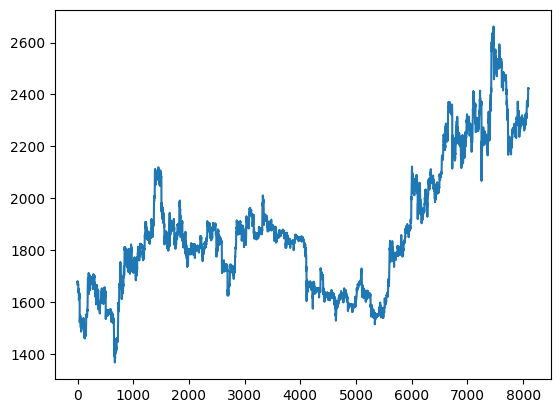

In [18]:
data['close'].plot()

# Fifth trial

In [37]:
states_trade = {'offtrade': 0, 'long': 1, 'short': 2}
states_cumulative = {'neutral': 0, 'positive': 1, 'negative': 2}
states_global = {'neutral': 0, 'profit': 1, 'loss': 2}

import itertools

state_space = []
for combo in itertools.product(states_trade.values(), states_cumulative.values(), states_global.values()):
    state_space.append(combo)

actions = {'hold': 0, 'buy': 1, 'sell': 2}
action_space = [i for i in actions.values()]

In [38]:
import numpy as np

class MyQLearningAgent5:
    def __init__(self, data, states, actions, alpha=0.3, gamma=0.7, epsilon=0.3):
        self.data = data
        
        self.states = states
        self.actions = actions
        self.pseudo_actions = []
        
        self.num_states = len(states)
        self.num_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((self.num_states, self.num_actions))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.Q[self.states.index(state)])]

    def update_q_table(self, state, action, reward, next_state):
        self.Q[self.states.index(state), self.actions.index(action)] += self.alpha * (
                reward + self.gamma * np.max(self.Q[self.states.index(next_state)]) -
                self.Q[self.states.index(state), self.actions.index(action)])

    def train(self, num_episodes):
        for episode in range(num_episodes):
            total_reward = 0
            state = [0, 0, 0]
            price_recent = []

            for i in range(1, len(self.data)):
                price_open = self.data['close'].iloc[i] # position open price
                price_recent.append(1) if self.data['close'].iloc[i-1] > price_open else price_recent.append(0)

                if price_recent.count(1) > price_recent.count(0):
                    state[1] = 1
                else:
                    state[1] = 2
                
                if state[0] == 0:
                    self.pseudo_actions = [1, 2]
                elif state[0] == 1:
                    self.pseudo_actions = [0, 2]
                elif state[0] == 2:
                    self.pseudo_actions = [0, 1]

                j = i+1
                while j < len(self.data):
                    action = None
                    while not action in self.pseudo_actions:
                        action = self.choose_action(tuple(state))

                    delta_t = j - i

                    if action == 1:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent.append(1) if self.data['close'].iloc[j] > self.data['close'].iloc[j-1] else price_recent.append(0)
                        
                        reward = self.get_reward(tuple(state), action, delta_t, price_recent, price_delta)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent.count(1) > price_recent.count(0):
                            next_state = [ state[0], 1, next_state[2]]
                        else:
                            next_state = [ state[0], 2, next_state[2]]
                        
                        if state[0] == 0:
                            next_state = [ 1, next_state[1], next_state[2]]
                        elif state[0] == 2:
                            next_state = [ 0, next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    elif action == 2:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent.append(1) if self.data['close'].iloc[j] > self.data['close'].iloc[j-1] else price_recent.append(0)

                        reward = self.get_reward(tuple(state), action, delta_t, price_recent, price_delta)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent.count(1) > price_recent.count(0):
                            next_state = [ state[0], 1, next_state[2]]
                        else:
                            next_state = [ state[0], 2, next_state[2]]
                        
                        if state[0] == 0:
                            next_state = [ 2, next_state[1], next_state[2]]
                        elif state[0] == 1:
                            next_state = [ 0, next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    elif action == 0:
                        price_delta = self.data['close'].iloc[j] - price_open
                        price_recent.append(1) if self.data['close'].iloc[j] > self.data['close'].iloc[j-1] else price_recent.append(0)

                        reward = self.get_reward(tuple(state), action, delta_t, price_recent, price_delta)

                        if price_delta > 0:
                            next_state = [ state[0], state[1], 1]
                        elif price_delta < 0:
                            next_state = [ state[0], state[1], 2]
                        else:
                            next_state = [ state[0], state[1], 0]

                        if price_recent.count(1) > price_recent.count(0):
                            next_state = [ state[0], 1, next_state[2]]
                        else:
                            next_state = [ state[0], 2, next_state[2]]
                        
                        if state[0] == 1:
                            next_state = [ state[0], next_state[1], next_state[2]]
                        elif state[0] == 2:
                            next_state = [ state[0], next_state[1], next_state[2]]

                        self.update_q_table(tuple(state), action, reward, tuple(next_state))
                        state = next_state

                    j += 1
                    
                    # Check for terminal state
                    if state[0] == 0:
                        break

                total_reward += reward

            print("Episode {}: Total Reward = {}".format(episode + 1, total_reward))
            # ---------------------------------------------------
    
    def get_reward(self, state, action, delta_t, price_recent, price_delta):
        
        if state[0] == 1 and action == 0:
            if price_recent.count(1) / len(price_recent) > .6:
                return 10 * (price_recent.count(1) / len(price_recent)) * delta_t
            else:
                return .5 * delta_t
        elif state[0] == 1 and action == 2:
            if price_delta > 0:
                return 5 * delta_t
            else:
                return -5 * delta_t
        elif state[0] == 2 and action == 0:
            if price_recent.count(0) / len(price_recent) > .6:
                return 10 * (price_recent.count(0) / len(price_recent)) * delta_t
            else:
                return .5 * delta_t
        elif state[0] == 2 and action == 1:
            if price_delta < 0:
                return 5 * delta_t
            else:
                return -5 * delta_t
        else:
            return 0

In [42]:
agent5 = MyQLearningAgent5(data, state_space, action_space)

In [43]:
agent5.train(num_episodes=5)

Episode 1: Total Reward = 20930
Episode 2: Total Reward = 13805
Episode 3: Total Reward = 14151.0
Episode 4: Total Reward = 15082.0
Episode 5: Total Reward = 17070


In [44]:
agent5.Q

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   5.39434277,   1.8586392 ],
       [  0.        ,  10.01246108,   2.69313544],
       [  0.        ,   2.29113787,   3.33274507],
       [  0.        ,   0.96503622,   9.47641319],
       [  0.        ,   9.29970192,   6.1816317 ],
       [  0.        ,   2.50393439,   6.57927972],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   9.51300762,   6.9160811 ],
       [  0.        ,   8.04088591,  17.58006156],
       [  3.95516013,   3.25798344, -11.26325323],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   3.68990234,  12.01950534],
       [  0.        ,   1.54157325, -29.33213126],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

In [45]:
import pickle

# Specify the file path where you want to save the pickled Q-matrix
file_path = 'q_matrix.pkl'

# Pickle the Q-matrix and save it to a file
with open(file_path, 'wb') as f:
    pickle.dump(agent5.Q, f)